In [1]:
import gc, random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

from matplotlib.ticker import FixedLocator, FixedFormatter

from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.decomposition import PCA
from sklearn import metrics

from sklego.mixture import BayesianGMMClassifier

from scipy import stats
from scipy.stats import norm

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

import optuna

import tqdm

## Seed everything

In [2]:
seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

## Load Data

In [3]:
df = pd.read_csv('../../../Data/Tabular Playground Series/tabular-playground-series-jul-2022/data.csv')
df.shape

(98000, 30)

In [4]:
df.head(2)

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541


In [5]:
X_train = df.drop('id', axis=1)

In [6]:
X_train.head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541


In [7]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
f_00,98000.0,0.001220,1.002801,-4.732235,-0.675226,0.002022,0.677271,4.490521
f_01,98000.0,0.005580,1.000742,-4.202795,-0.670985,0.006650,0.677746,4.324974
f_02,98000.0,-0.001042,1.001373,-4.377021,-0.672779,-0.000324,0.677086,4.560247
f_03,98000.0,-0.000700,1.000422,-4.010826,-0.672540,-0.003185,0.672097,4.399373
f_04,98000.0,-0.003522,1.003061,-4.535903,-0.682510,-0.003307,0.677589,4.050549
f_05,98000.0,-0.001612,1.000532,-4.300767,-0.675066,0.001024,0.673344,4.710316
f_06,98000.0,-0.003042,0.997434,-4.894525,-0.680421,-0.002053,0.668112,3.998595
f_07,98000.0,5.545918,3.691840,0.000000,3.000000,5.000000,8.000000,32.000000
f_08,98000.0,6.763061,4.152348,0.000000,4.000000,6.000000,9.000000,30.000000
f_09,98000.0,8.193163,5.904919,0.000000,4.000000,7.000000,11.000000,44.000000


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_00    98000 non-null  float64
 1   f_01    98000 non-null  float64
 2   f_02    98000 non-null  float64
 3   f_03    98000 non-null  float64
 4   f_04    98000 non-null  float64
 5   f_05    98000 non-null  float64
 6   f_06    98000 non-null  float64
 7   f_07    98000 non-null  int64  
 8   f_08    98000 non-null  int64  
 9   f_09    98000 non-null  int64  
 10  f_10    98000 non-null  int64  
 11  f_11    98000 non-null  int64  
 12  f_12    98000 non-null  int64  
 13  f_13    98000 non-null  int64  
 14  f_14    98000 non-null  float64
 15  f_15    98000 non-null  float64
 16  f_16    98000 non-null  float64
 17  f_17    98000 non-null  float64
 18  f_18    98000 non-null  float64
 19  f_19    98000 non-null  float64
 20  f_20    98000 non-null  float64
 21  f_21    98000 non-null  float64
 22

<AxesSubplot:>

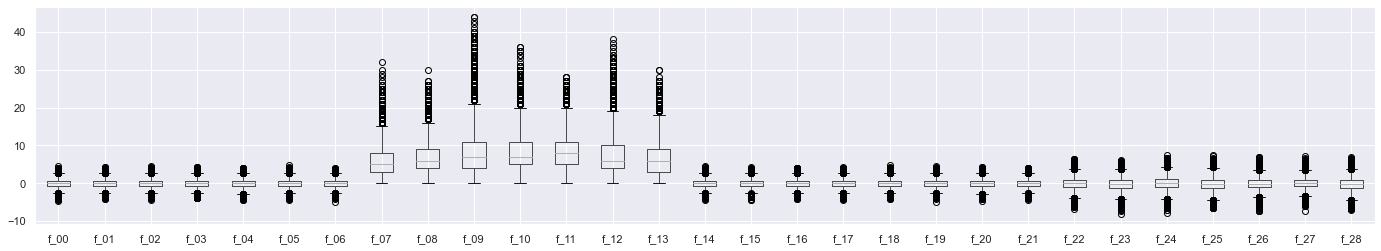

In [9]:
X_train.boxplot(figsize=(24,4))

## Probably a good idea to scale the data

In [10]:
# standard_scaler = StandardScaler()
# X_train = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)

power_transformer = PowerTransformer()
X_train = pd.DataFrame(power_transformer.fit_transform(X_train), columns=X_train.columns)

X_train.head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,1.039938,...,-0.472922,-0.753925,-0.763110,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234
1,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,-0.179925,...,-0.423594,-0.088164,-1.777545,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652


<AxesSubplot:>

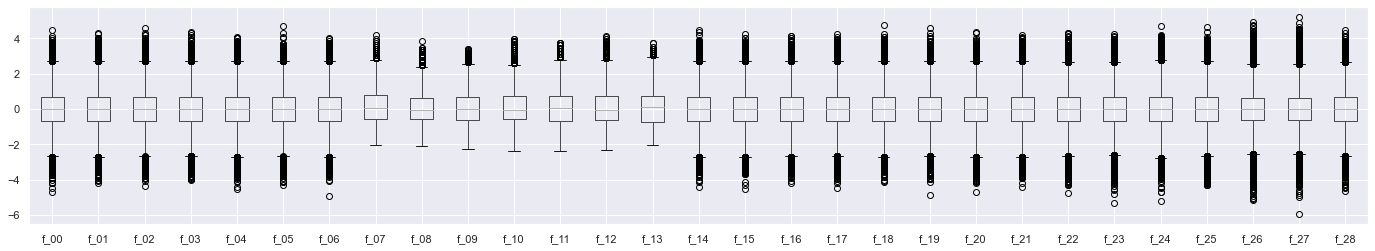

In [11]:
X_train.boxplot(figsize=(24,4))

In [12]:
# for col in X_train.columns:    
#     plt.figure(figsize=(5,5))
#     res = stats.probplot(X_train[col], plot=plt)

## Keep a copy of X_train

In [13]:
X_train_orig = X_train.copy(deep=True)

## Let's remove outliers from all columns 

In [ ]:
# print(f'X_train.shape={X_train.shape}')

# for col in X_train.columns:
#     mean = X_train[col].mean()
#     std  = X_train[col].std()
    
#     upper_bound = mean + 3*std
#     lower_bound = mean - 3*std
    
#     X_train = X_train[(X_train[col] > lower_bound) & (X_train[col] < upper_bound)]
    
# print(f'X_train.shape={X_train.shape}')

## Let's look at quantiles plots again

In [ ]:
# for col in X_train.columns:    
#     plt.figure(figsize=(5,5))
#     res = stats.probplot(X_train[col], plot=plt)

In [ ]:
# X_train.boxplot(figsize=(16,4))

# How much of the variance each number of components explain?

* We see that on average each new component adds about 4% of explained variance (with an exception of the first 2 components, where contribution is 6.21% and 4.93%.

In [ ]:
# for n in range(1,30):
#     pca = PCA(n_components=n, random_state=seed)

#     p = pca.fit_transform(X_train)

#     inv_transform = pca.inverse_transform(p)

#     plt.figure(figsize=(12,2))
#     pd.DataFrame(inv_transform, columns=X_train.columns).std().plot.bar(title=f'n_components={n} | variance explained={np.round(np.sum(pca.explained_variance_ratio_)*100,2)}')

## Create 7 clusters via an ensamble of BGMs to build a supervised learning problem

In [ ]:
predictions = []
predictions_proba = []

for i in range(10):

    bgm = BayesianGaussianMixture(
        n_components=7, 
        covariance_type='full', 
        max_iter=100, 
        random_state=seed + i*20, 
        n_init=5
    )

    bgm.fit(X_train)
    
    assert bgm.converged_ == True
    
    print(f'i={i} completed')
    
    predictions.append(bgm.predict(X_train))
    predictions_proba.append(bgm.predict_proba(X_train))

In [ ]:
rand_scores = []
for i in range(len(predictions)):
    rand_scores_row = []
    for j in range(len(predictions)):        
        rand_index = metrics.rand_score(
            labels_true=predictions[i],
            labels_pred=predictions[j]
        ) 
        rand_scores_row.append(rand_index)
    rand_scores.append(rand_scores_row)
    
print(np.round(rand_scores,2))

In [ ]:
predictions = []
predictions_proba = []

for i in range(10):

    bgm = BayesianGaussianMixture(
        n_components=7, 
        covariance_type='full', 
        max_iter=100, 
        random_state=seed + i*2000, 
        n_init=5
    )

    bgm.fit(X_train)
    
    assert bgm.converged_ == True
    
    print(f'i={i} completed')
    
    predictions.append(bgm.predict(X_train))
    predictions_proba.append(bgm.predict_proba(X_train))

In [ ]:
rand_scores = []
for i in range(len(predictions)):
    rand_scores_row = []
    for j in range(len(predictions)):        
        rand_index = metrics.rand_score(
            labels_true=predictions[i],
            labels_pred=predictions[j]
        ) 
        rand_scores_row.append(rand_index)
    rand_scores.append(rand_scores_row)
    
print(np.round(rand_scores,2))

In [14]:
bgm = BayesianGaussianMixture(
    n_components=7, 
    covariance_type='full', 
    max_iter=300, 
    random_state=seed, 
    n_init=3,
    init_params='k-means++'
)

bgm.fit(X_train)

BayesianGaussianMixture(init_params='k-means++', max_iter=300, n_components=7,
                        n_init=3, random_state=42)

In [15]:
bgm.converged_

True

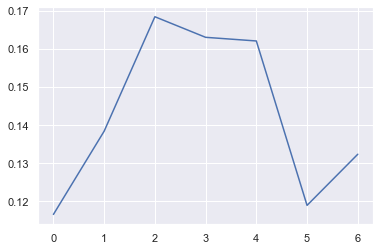

In [16]:
plt.plot(bgm.weights_)

In [17]:
y_train = bgm.predict(X_train)
proba = bgm.predict_proba(X_train)

In [ ]:
y_train[:5]

In [ ]:
np.round(proba[:10],2)

In [ ]:
max_proba = np.max(proba,axis=1)

In [ ]:
max_proba[:10]

In [ ]:
_ = plt.hist(max_proba, bins=50)

In [ ]:
sns.boxplot(data=max_proba)

In [ ]:
sure_idx = max_proba >= 0.6

In [ ]:
sure_samples = X_train[sure_idx]
sure_y = y_train[sure_idx]
print(f'sure_samples.shape={sure_samples.shape}')
print(f'sure_y.shape={sure_y.shape}')

In [ ]:
sure_samples.head(2)

In [ ]:
def objective(trial, n_splits=10, shuffle=True, get_info=False):
    
    param = {        
        'verbose': 0,
        'random_state': seed,
        'loss_function': 'MultiClass',
        'task_type': 'GPU',
        'iterations': trial.suggest_int('iterations', 10, 1000, 10),
        'depth': trial.suggest_int('depth', 1, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'random_strength': trial.suggest_uniform('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 30),
    }
    
    model = cb.CatBoostClassifier(**param)
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)    
    
    scores = []
    models = []

    for train_index, test_index in kf.split(sure_samples, sure_y): 

        train_dataset = cb.Pool(
            data=sure_samples.iloc[train_index,:], 
            label=sure_y[train_index],
        )
        
        eval_dataset = cb.Pool(
            data=sure_samples.iloc[test_index,:], 
            label=sure_y[test_index],
        )
        
        model.fit(
            train_dataset,            
            early_stopping_rounds=200,
            verbose=0,            
        )

        y_test_pred = model.predict(eval_dataset).reshape(-1)
        
        score = metrics.adjusted_rand_score(
            labels_true=sure_y[test_index],
            labels_pred=y_test_pred
        )
        
        scores.append(score)
        models.append(model)

    scores = np.array(scores)
    
    if get_info:
        
        info = {
            'mean_score': np.mean(scores), 
            'score_std' : np.std(scores), 
            'scores': scores, 
            'models': models,
        }
        
        return info
    else:
        return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='maximize', study_name='tps_clustering')
study.optimize(objective, n_trials=10, show_progress_bar=True)

In [ ]:
study.best_value

In [ ]:
study.best_params

In [ ]:
info = objective(optuna.trial.FixedTrial(study.best_params), get_info=True)

In [ ]:
best_models = info['models']

## A bag of CatBoost models for predictions

In [ ]:
predict_proba = 0

for model in best_models:
    predict_proba += model.predict_proba(X_train_orig)

In [ ]:
predictions = np.argmax(predict_proba, axis=1)
predictions[:5]

## New trick

In [21]:
bgm_predictions = bgm.predict(X_train)

In [22]:
best_data =['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22','f_23', 'f_24', 'f_25','f_26','f_27', 'f_28']

In [29]:
X = np.array(X_train_orig[best_data])
# X = np.array(X_train_orig)
y = np.array(bgm_predictions)

In [30]:
bgmc = BayesianGMMClassifier(
    n_components=7,
    random_state = seed,
    tol = 1e-3,
    covariance_type = 'full',
    max_iter = 300,
    n_init=15,
    init_params='k-means++'                             
)

# fitting and probability prediction
bgmc.fit(X,y)
predict = bgmc.predict(X)
pred_seed = bgmc.predict_proba(X)

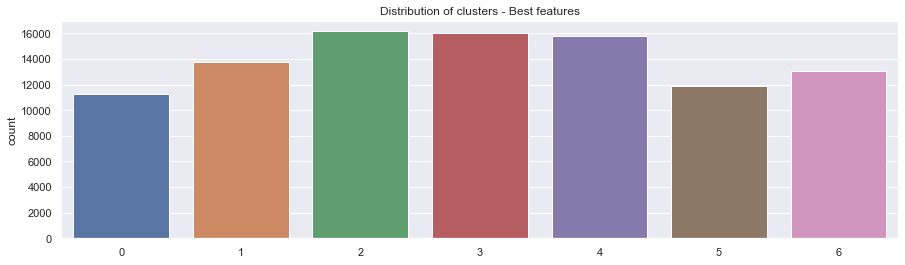

In [31]:
sns.set(rc={'figure.figsize':(15,4)})
pl = sns.countplot(x=predict)
pl.set_title("Distribution of clusters - Best features")
plt.show()

In [32]:
submission = pd.read_csv('../../../Data/Tabular Playground Series/tabular-playground-series-jul-2022/sample_submission.csv')
# submission['Predicted'] = predictions
submission['Predicted'] = predict
submission.to_csv("submission.csv", index=False)

## Your most recent submission scored 0.73634, which is an improvement of your previous score of 0.62491. Great job!

### Leaderboard Score

<img src="bgmc_1.png">

# Ideas to try

* try using an ensamble of BGMs for sure_samples clustering
* blending and stacking models together
* different threshold for sure_samples
* sklearn.metrics.balanced_accuracy_score for metrics instead of adjusted_rand_index
* roc_auc_score(labels, probas, average="weighted", multi_class="ovo") for metrics
* ExtraTreesClassifier
* KNN
* Quadratic Discriminant Analysis
* SVC
* XGBoost
* LightGBM